#  Forecasting taxi orders

The company "Chetenkoe Taxi" has collected historical data on taxi orders at airports. In order to attract more drivers during peak load we need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the RMSE metric in the test sample should be no more than 48.

We need to:

- Download the data and resample it one hour at a time.
- Analyze the data.
- Train different models with different hyperparameters. Make a test sample of 10% of the original data.
- Check the data on the test sample and draw conclusions.

The data is in the `taxi.csv` file. The number of orders is in the`num_orders` column.

## Data preprocessing

In [1]:
# pip install pandas_profiling

In [2]:
# !pip install fast_ml

In [3]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [4]:
data = pd.read_csv('taxi.csv')

In [5]:
data['datetime'] = data['datetime'].astype('datetime64')
data = data.set_index('datetime')

- Conversion of dates column to `'datetime64'`;
- We use the date as the index of the dataframe;
- Sort the index;
- the interval is one hour.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Number of orders')

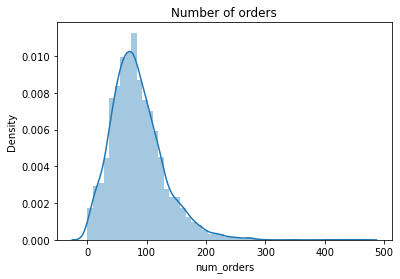

In [10]:
sns_plot = sns.distplot(data['num_orders'])
plt.title('Number of orders')

In [11]:
data_part = data['2018-08-10':'2018-08-11']

<AxesSubplot:xlabel='datetime'>

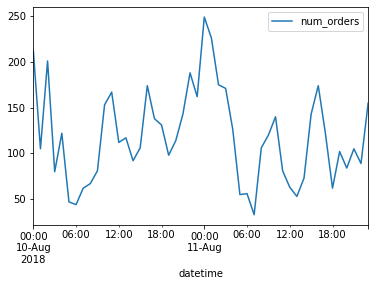

In [12]:
data_part.plot()

In [13]:
print(data.index.is_monotonic)

True


## EDA

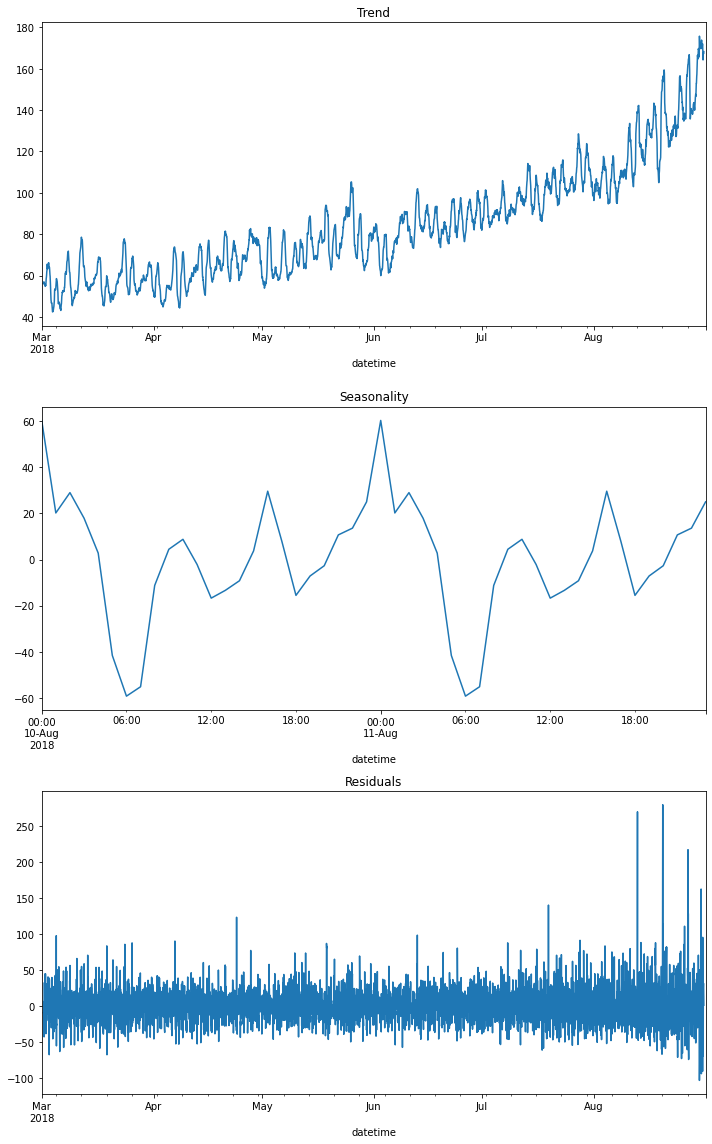

In [14]:
decompose = seasonal_decompose(data)

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decompose.seasonal['2018-08-10':'2018-08-11'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

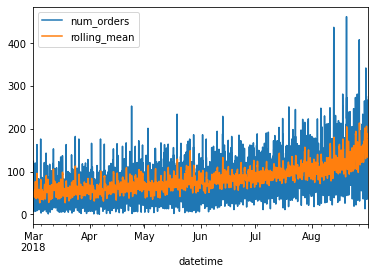

In [15]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot()

- Trend indicates an increase in orders;
- Seasonality indicates a high demand for taxis at night and early in the morning at 6 am the demand is low;
- Seasonality was visualized on a shorter interval;
- Since the trend is changing it means that the average is changing it follows that the process is unsteady-state.

## Model training

In [16]:
# DATA is local variable
def make_features(DATA, max_lag, rolling_mean_size):
    DATA['year'] = DATA.index.year
    DATA['month'] = DATA.index.month
    DATA['day'] = DATA.index.day
    DATA['dayofweek'] = DATA.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        DATA['lag_' + str(lag)] = DATA['num_orders'].shift(lag)

    DATA['rolling_mean'] = DATA['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(data, 400, 200)
data = data.dropna()

C:\Users\leint\AppData\Local\Temp\ipykernel_1976\3498644892.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DATA['lag_' + str(lag)] = DATA['num_orders'].shift(lag)
C:\Users\leint\AppData\Local\Temp\ipykernel_1976\3498644892.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DATA['lag_' + str(lag)] = DATA['num_orders'].shift(lag)
C:\Users\leint\AppData\Local\Temp\ipykernel_1976\3498644892.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [18]:
data.head(5)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_391,lag_392,lag_393,lag_394,lag_395,lag_396,lag_397,lag_398,lag_399,lag_400
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-17 16:00:00,53,59.275,2018,3,17,5,82.0,65.0,43.0,49.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-17 17:00:00,41,59.360,2018,3,17,5,53.0,82.0,65.0,43.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-17 18:00:00,83,59.350,2018,3,17,5,41.0,53.0,82.0,65.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-17 19:00:00,34,59.550,2018,3,17,5,83.0,41.0,53.0,82.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-17 20:00:00,57,59.475,2018,3,17,5,34.0,83.0,41.0,53.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0


In [19]:
train_val, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_val, shuffle=False, test_size=0.2)

train_features = train.drop('num_orders',axis = 1)
train_target = train['num_orders']

valid_features = valid.drop('num_orders',axis =1)
valid_target = valid['num_orders']

test_features = test.drop('num_orders',axis = 1)
test_target = test['num_orders']

In [20]:
# linear regression

model_1 = None
linear_model = LinearRegression()
linear_model.fit(train_features, train_target)
model_1 = linear_model 
model_regressor_answer = linear_model.predict(valid_features)
model_regressor_rmse = mean_squared_error(valid_target,model_regressor_answer) ** 0.5

print('RMSE of LINEAR REGRESSION',model_regressor_rmse)

RMSE of LINEAR REGRESSION 28.413480177710166


In [21]:
# DecisionTreeRegressor

model_2 = None
tree_model = DecisionTreeRegressor(max_depth=6,random_state=12345)
tree_model.fit(train_features, train_target)
model_2 = tree_model
tree_model_answer = tree_model.predict(valid_features)
tree_model_rmse = mean_squared_error(valid_target,tree_model_answer) ** 0.5

print('RMSE of DecisionTreeRegressor',tree_model_rmse)

RMSE of DecisionTreeRegressor 32.93576637278022


In [22]:
# RandomForestRegressor

model_3 = None


for i in range(1,51):
    for y in range(1,7):
        forest_model = RandomForestRegressor(n_estimators=i,max_depth=y, random_state=12345,bootstrap=True)
        forest_model.fit(train_features, train_target)
        model_3 = forest_model
        forest_model_answer = forest_model.predict(valid_features)
        forest_model_rmse = mean_squared_error(valid_target,forest_model_answer) ** 0.5
        if forest_model_rmse < 30.2:
            print('RMSE of RandomForestRegressor',forest_model_rmse)
            print('n_estimators = ',i)
            print('max_depth = ', y)
            break
    if forest_model_rmse < 30.2:
        break       

RMSE of RandomForestRegressor 30.16388775668931
n_estimators =  6
max_depth =  5


In [23]:
# CatBoostRegressor

model_4 = None
model_cat = CatBoostRegressor(n_estimators = 200, loss_function = 'MAE', eval_metric = 'RMSE')
model_cat.fit(train_features, train_target, verbose=50)
model_4 = model_cat
predicted_valid2 = model_cat.predict(valid_features)
rmse_cat = (mean_squared_error(valid_target, predicted_valid2))**0.5

print('RMSE of CatBoostRegressor',rmse_cat)

0:	learn: 34.3950265	total: 152ms	remaining: 30.2s
50:	learn: 22.0931270	total: 796ms	remaining: 2.33s
100:	learn: 19.6274951	total: 1.43s	remaining: 1.4s
150:	learn: 18.4728722	total: 2.07s	remaining: 671ms
199:	learn: 17.7871692	total: 2.69s	remaining: 0us
RMSE of CatBoostRegressor 31.066881603930423


- Applied the `make_features` function to create features;
- The data was divided into three samples. For the test sample 10% of the data was taken;
- trained 4 different models.
    
The best was linear regression

## Check up

RMSE on the test sample for linear regression is less than 48

In [24]:
# testing a linear regression model on a test set

linear_test = model_1.predict(test_features)
rmse_linear_test = mean_squared_error(test_target, linear_test)**0.5

print('RMSE of LINEAR REGRESSION',model_regressor_rmse)

RMSE of LINEAR REGRESSION 28.413480177710166


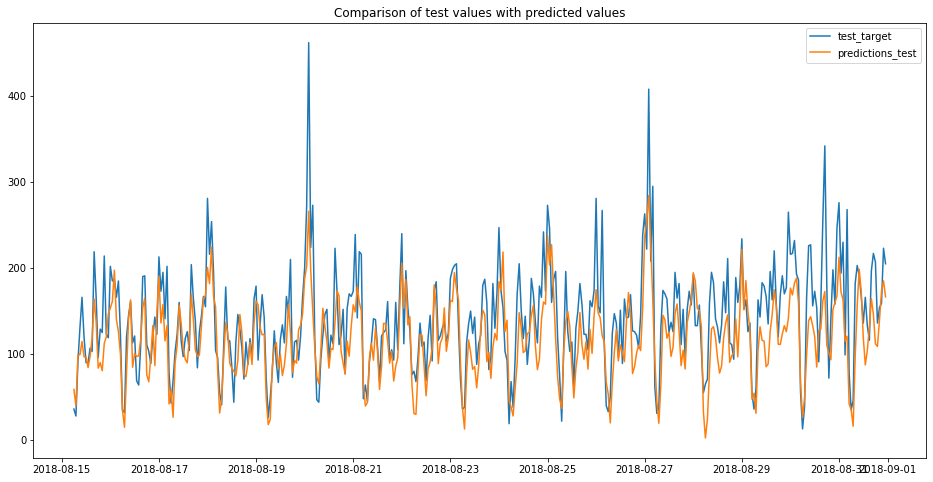

In [25]:
plt.figure(figsize=(16, 8))

plt.plot(test_target, label='test_target')
plt.plot(test_target.index, linear_test, label='predictions_test')

plt.title('Comparison of test values with predicted values')
plt.legend()
plt.show()

In [26]:
# Checking the model for adequacy by the mean

predicted_mean = np.ones(test.shape[0]) * train['num_orders'].mean()
rmse_mean = mean_squared_error(test_target, predicted_mean) ** 0.5

print("RMSE score by mean :", rmse_mean)

RMSE score by mean : 89.59682264163463


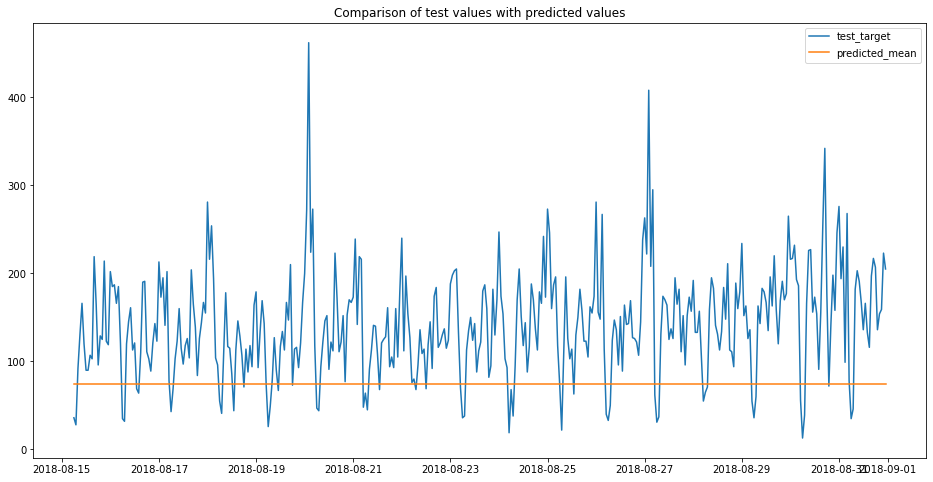

In [27]:
plt.figure(figsize=(16, 8))

plt.plot(test_target, label='test_target')
plt.plot(test_target.index, predicted_mean, label='predicted_mean')

plt.title('Comparison of test values with predicted values')
plt.legend()
plt.show()

In [28]:
# Checking the model for adequacy by the subsequent value

predicted_previous = test['num_orders'].shift()
predicted_previous.iloc[0] = test_target.iloc[-1]
rmse_previous = mean_squared_error(test_target, predicted_previous)**0.5
print("RMSE score for last. meaning :", rmse_previous )

RMSE score for last. meaning : 59.7922606016924


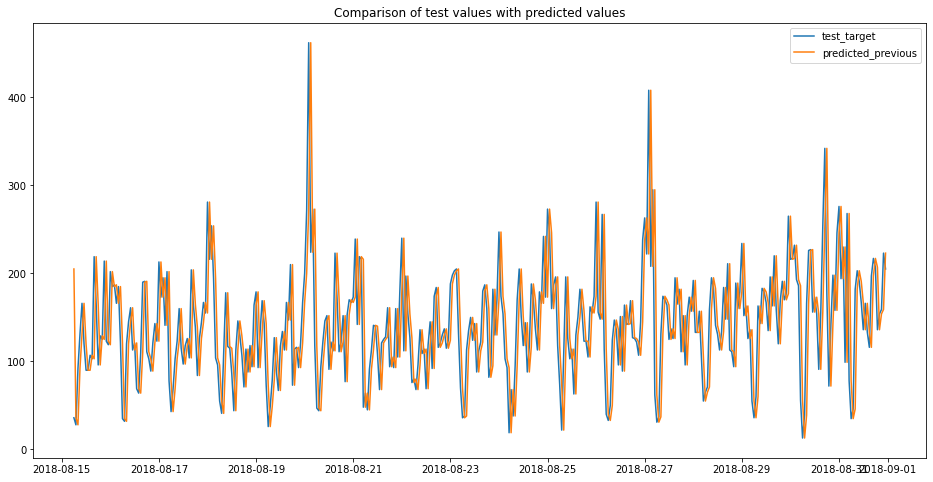

In [29]:
plt.figure(figsize=(16, 8))

plt.plot(test_target, label='test_target')
plt.plot(test_target.index, predicted_previous, label='predicted_previous')

plt.title('Comparison of test values with predicted values')
plt.legend()
plt.show()

**Conclusion:**

- RMSE on the test data set is approximately 28 for the linear regression model which is significantly less than the error obtained based on the predictions for the previous value in the original data equal to 59.
- Alternatively we can use the decision tree, random forest and catboost model which also gives high prediction accuracy with a similar set of input parameters.